In [118]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [40]:

# Initialize an empty list to store the images
face_points = []

# Use glob to find all .png files in the '01_Indoor' and '01_Outdoor' folders
image_folder = r'.\300W\*\*.png'

# Get all image paths from both folders
face_images = glob(pathname=image_folder)

for i in face_images:
    face_points.append(i.replace(".png", ".pts"))


# Now face_images contains all the images loaded from both folders
print(face_images[:10])
print(face_points[:10])


['.\\300W\\01_Indoor\\indoor_001.png', '.\\300W\\01_Indoor\\indoor_002.png', '.\\300W\\01_Indoor\\indoor_003.png', '.\\300W\\01_Indoor\\indoor_004.png', '.\\300W\\01_Indoor\\indoor_005.png', '.\\300W\\01_Indoor\\indoor_006.png', '.\\300W\\01_Indoor\\indoor_007.png', '.\\300W\\01_Indoor\\indoor_008.png', '.\\300W\\01_Indoor\\indoor_009.png', '.\\300W\\01_Indoor\\indoor_010.png']
['.\\300W\\01_Indoor\\indoor_001.pts', '.\\300W\\01_Indoor\\indoor_002.pts', '.\\300W\\01_Indoor\\indoor_003.pts', '.\\300W\\01_Indoor\\indoor_004.pts', '.\\300W\\01_Indoor\\indoor_005.pts', '.\\300W\\01_Indoor\\indoor_006.pts', '.\\300W\\01_Indoor\\indoor_007.pts', '.\\300W\\01_Indoor\\indoor_008.pts', '.\\300W\\01_Indoor\\indoor_009.pts', '.\\300W\\01_Indoor\\indoor_010.pts']


In [41]:
# Function to read points from a .pts file
def read_pts_file(pts_file):
    points = []
    with open(pts_file, 'r') as file:
        lines = file.readlines()[3:-1]  # Skip the first 3 lines and the last curly brace
        for line in lines:
            x, y = line.strip().split()
            points.append((float(x), float(y)))
    return points

In [42]:
# Function to resize points based on new image size
def resize_points(points, old_size, new_size):
    old_width, old_height = old_size
    new_width, new_height = new_size
    scale_x = new_width / old_width
    scale_y = new_height / old_height
    resized_points = [(x * scale_x, y * scale_y) for (x, y) in points]
    return resized_points

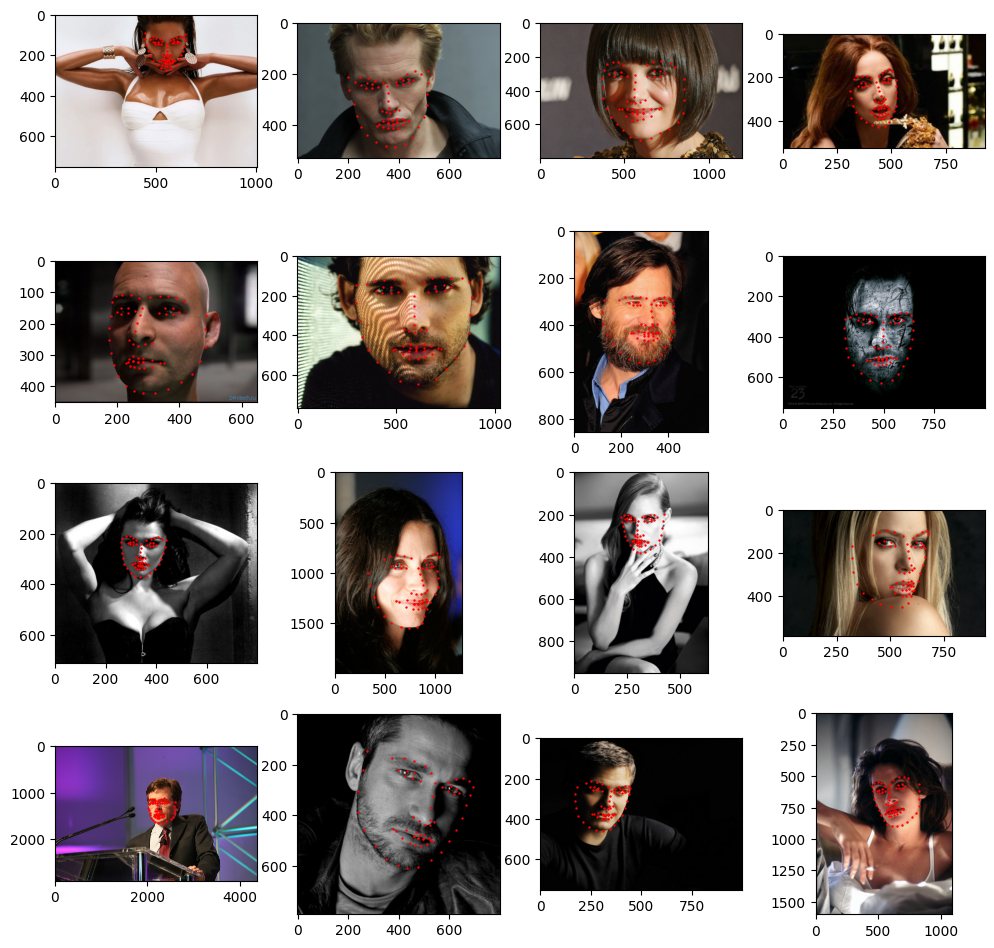

In [43]:
def plot_from_image_path(rows, columns, image_list):
    fig = plt.figure(figsize=(12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        image_file = image_list[i-1]
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Construct the corresponding .pts file path (assuming it's in the same folder with .pts extension)
        pts_file = os.path.splitext(image_file)[0] + '.pts'
        
        # Read the points from the .pts file
        if os.path.exists(pts_file):
            points = read_pts_file(pts_file)
        else:
            points = []
            
        
        
        plt.imshow(image)
        
        # Plot the points if available
        if points:
            xs, ys = zip(*points)  # Separate the x and y coordinates
            plt.scatter(xs, ys, c='red', s=0.5)  # Plot points in red
        
    plt.imshow
    
plot_from_image_path(4, 4, face_images)

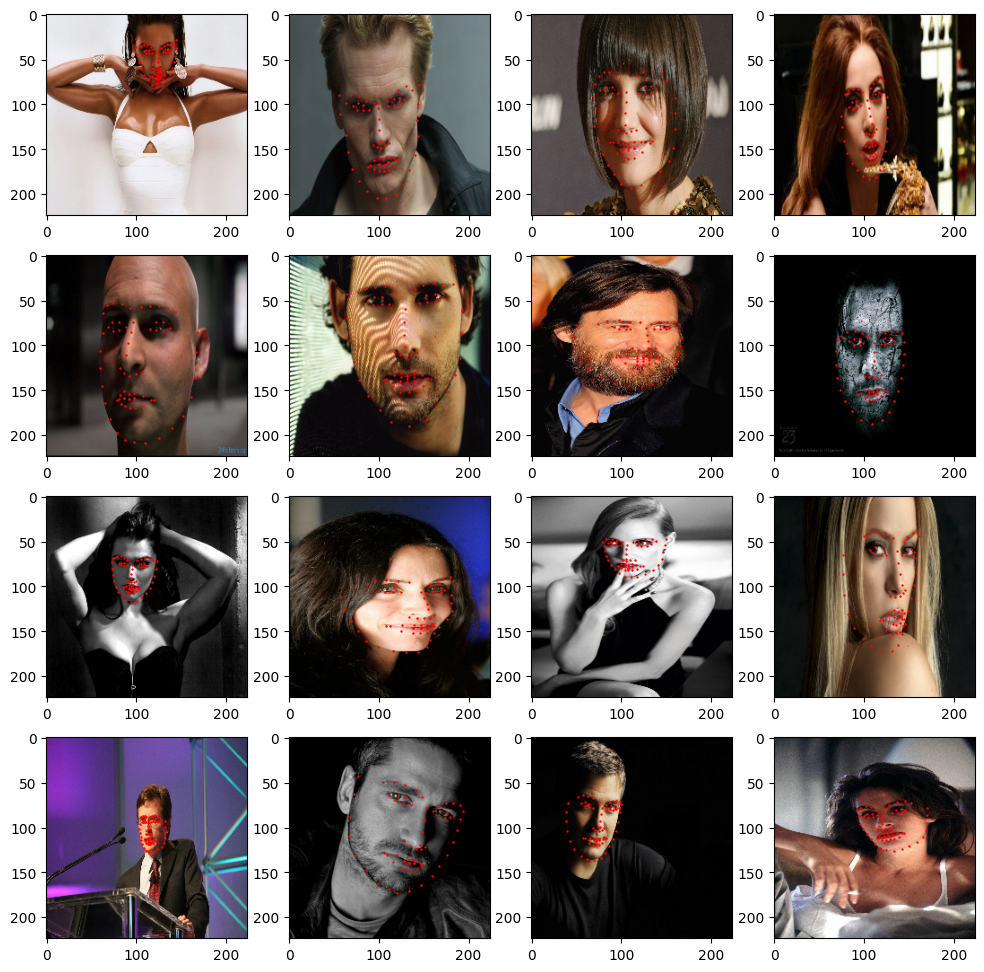

In [44]:
def plot_from_image_path(rows, columns, image_list):
    fig = plt.figure(figsize=(12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        image_file = image_list[i-1]
        image = cv2.imread(image_file)
        
        
        # Get the original image size
        old_size = image.shape[1], image.shape[0]  # (width, height)
        
        # Resize the image to 224x224
        new_size = (224, 224)
        image_resized = cv2.resize(image, new_size)
        
        # Convert from BGR to RGB for displaying
        image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        
        
        
        # Construct the corresponding .pts file path (assuming it's in the same folder with .pts extension)
        pts_file = os.path.splitext(image_file)[0] + '.pts'
        
        # Read the points from the .pts file
        if os.path.exists(pts_file):
            points = read_pts_file(pts_file)
            # Resize the points to match the resized image
            points_resized = resize_points(points, old_size, new_size)
        else:
            points_resized = []
            
        
        
        plt.imshow(image_resized)
        
        # Plot the points if available
        if points:
            xs, ys = zip(*points_resized)  # Separate the x and y coordinates
            plt.scatter(xs, ys, c='red', s=0.5)  # Plot points in red
        
    plt.imshow
    
plot_from_image_path(4, 4, face_images)

In [131]:
# Custom dataset class to handle image transformations and augmentations
class FaceLandmarkDataset(Dataset):
    def __init__(self, image_paths, points_paths, transform=None, num_keypoints=68):
        self.image_paths = image_paths
        self.points_paths = points_paths
        self.transform = transform
        self.num_keypoints = num_keypoints  # Number of expected keypoints

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        points_path = self.points_paths[idx]
        
        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Get original image size
        old_size = image.shape[1], image.shape[0]  # (width, height)
        
        # Load points
        points = read_pts_file(points_path)
        
        # Check if the number of points is correct
        if len(points) != self.num_keypoints:
            raise ValueError(f"Expected {self.num_keypoints} keypoints, but got {len(points)} for {points_path}")

        # Apply any transformations
        sample = {'image': image, 'points': points, 'old_size': old_size}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [132]:
class PreprocessTransform:
    def __init__(self):
        self.resize = transforms.Resize((224, 224))  # Resize the image to 224x224
        self.to_tensor = transforms.ToTensor()       # Convert image to tensor

    def __call__(self, sample):
        image = sample['image']
        points = sample['points']
        old_size = sample['old_size']  # Original size of the image (width, height)

        # Convert image to PIL for transformations
        image = Image.fromarray(image)

        # Apply random horizontal flip
        if random.random() > 0.5:
            image = F.hflip(image)
            points = [(old_size[0] - x, y) for (x, y) in points]  # Flip keypoints horizontally

        # Apply random crop
        i, j, h, w = transforms.RandomResizedCrop.get_params(image, scale=(0.8, 1.0), ratio=(1.0, 1.0))
        image = F.resized_crop(image, i, j, h, w, (224, 224))  # Crop and resize to 224x224
        points = [(x - j, y - i) for (x, y) in points]  # Adjust keypoints for crop region

        # Ensure keypoints are within bounds of the cropped image (before resizing)
        points = [(x, y) for (x, y) in points if 0 <= x <= w and 0 <= y <= h]

        # Resize keypoints to match the resized image
        points = resize_points(points, (w, h), (224, 224))

        # Convert image to tensor and normalize
        image = self.to_tensor(image)
        
        return {'image': image, 'points': points}

In [133]:
# Dataset preparation
df = pd.DataFrame(data={'face_images': face_images, 'face_points': face_points})
df_train, df_test = train_test_split(df, test_size=0.15, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1765, random_state=42)

In [134]:
# Create dataset and dataloader for the training set
train_dataset = FaceLandmarkDataset(image_paths=df_train['face_images'].tolist(),
                                    points_paths=df_train['face_points'].tolist(),
                                    transform=PreprocessTransform())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [135]:
# Function to plot the dataset with keypoints
def plot_preprocessed_dataset(rows, columns, dataset):
    fig, axs = plt.subplots(rows, columns, figsize=(12, 12))
    for i, sample in enumerate(dataset):
        if i >= rows * columns:
            break
        ax = axs[i // columns, i % columns]
        image = sample['image'].permute(1, 2, 0).numpy()  # Convert to numpy for plotting
        points = sample['points']
        
        ax.imshow(image)
        xs, ys = zip(*points)  # Separate x and y coordinates
        ax.scatter(xs, ys, c='red', s=5)  # Plot points in red
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

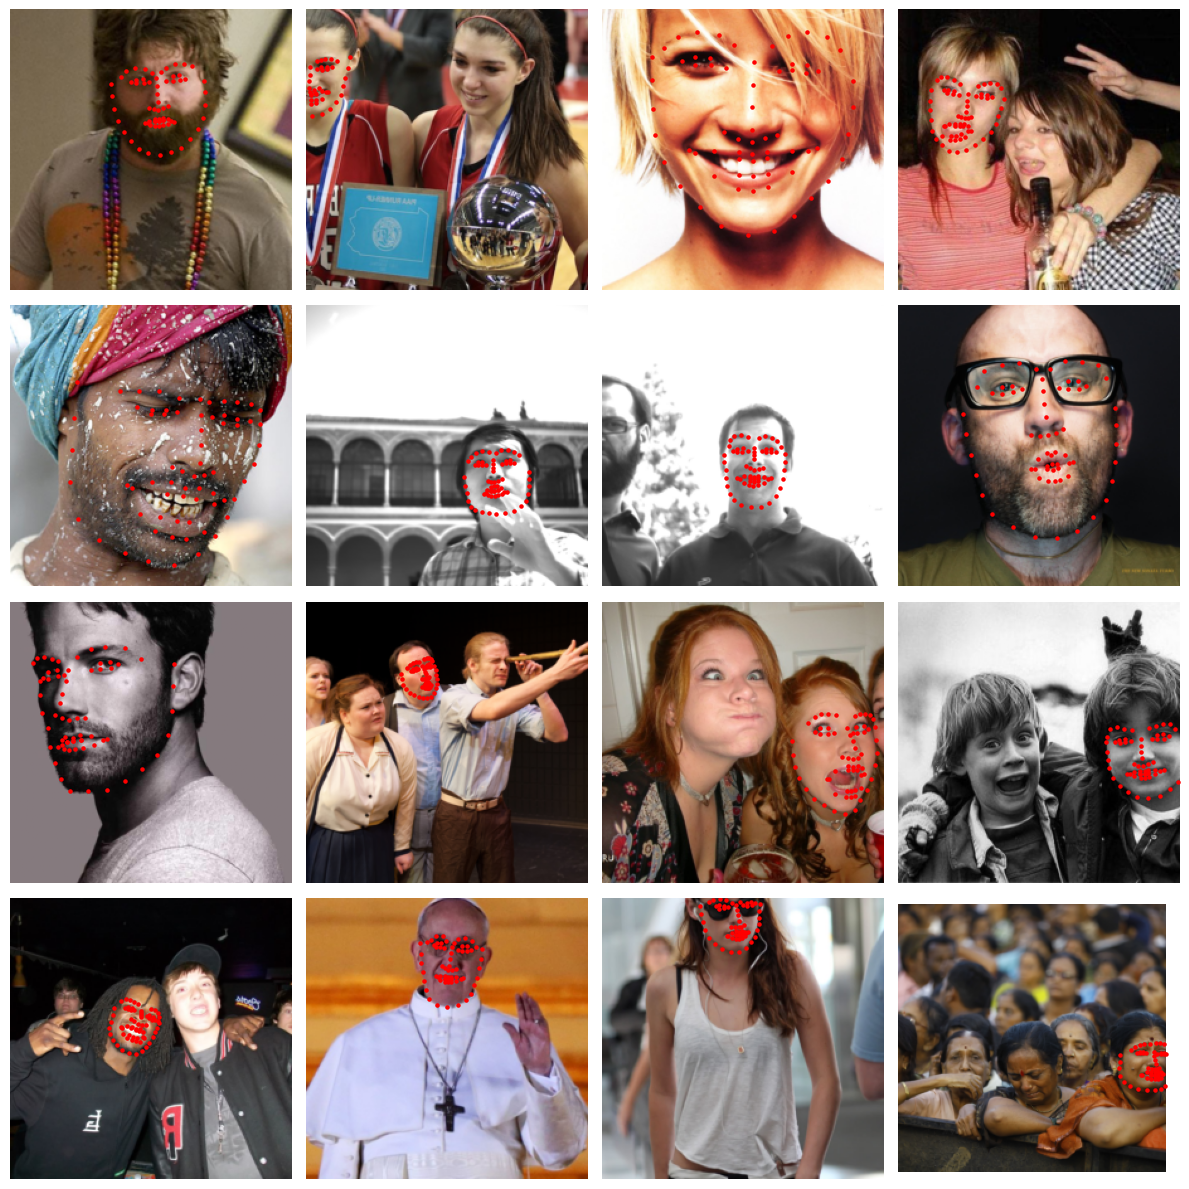

Training set size: (419, 2)
Validation set size: (91, 2)
Test set size: (90, 2)


In [136]:
# Plot the preprocessed dataset (first 16 images)
plot_preprocessed_dataset(4, 4, [train_dataset[i] for i in range(16)])

# Print the shapes of the resulting splits
print("Training set size:", df_train.shape)
print("Validation set size:", df_val.shape)
print("Test set size:", df_test.shape)

In [137]:
class MobileNetV2Keypoint(nn.Module):
    def __init__(self, num_keypoints):
        super(MobileNetV2Keypoint, self).__init__()
        
        # Load a pretrained MobileNetV2 model
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Freeze the feature extractor layers
        for param in self.mobilenet.features.parameters():
            param.requires_grad = False
        
        # Replace the last fully connected layer (classifier)
        # The new output layer will have 2 * num_keypoints units (x, y for each keypoint)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, 2 * num_keypoints)
    
    def forward(self, x):
        return self.mobilenet(x)

In [138]:
# Assuming we are detecting 68 keypoints
num_keypoints = 68
model = MobileNetV2Keypoint(num_keypoints=num_keypoints)

# Print model architecture to verify changes
print(model)

MobileNetV2Keypoint(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kern

In [139]:
# Define the MSE loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate scheduler (Reduce LR by 0.1 after N epochs of no improvement)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


In [140]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        for batch in train_loader:
            images = batch['image']
            keypoints = batch['points']
            
            # Move data to GPU if available
            if torch.cuda.is_available():
                images = images.cuda()
                keypoints = keypoints.cuda()
                model = model.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute MSE loss
            loss = criterion(outputs, keypoints.view(outputs.size()))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

        # Print the loss for this epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')

        # Validation step (optional)
        val_loss = validate_model(model, val_loader, criterion)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss}')

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)


In [141]:
def validate_model(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image']
            keypoints = batch['points']
            
            # Move data to GPU if available
            if torch.cuda.is_available():
                images = images.cuda()
                keypoints = keypoints.cuda()

            outputs = model(images)
            loss = criterion(outputs, keypoints.view(outputs.size()))
            val_loss += loss.item()

    return val_loss / len(val_loader)

In [142]:
# Assuming you have a validation loader created similarly to train_loader
val_dataset = FaceLandmarkDataset(image_paths=df_val['face_images'].tolist(),
                                  points_paths=df_val['face_points'].tolist(),
                                  transform=PreprocessTransform())
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Call the training loop
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)

RuntimeError: each element in list of batch should be of equal size